In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten
import warnings
warnings.filterwarnings('ignore')

2024-06-15 19:20:59.454107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 19:20:59.454234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 19:20:59.610817: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_size = 224
no_channel = 3

In [3]:
dir_path = '/kaggle/input/cv-project-data'
train_path = os.path.join(dir_path,'train')
test_path = os.path.join(dir_path,'test')
val_path = os.path.join(dir_path,'valid')

In [4]:
import csv
def labels_data(dir):
    path_csv = os.path.join(dir,'_classes.csv')
    file_names = []
    labels = []
    with open(path_csv,'rt') as f:
        header = next(f)
        for line in f:
            row = line.split(",")
            file_names.append(row[0])
            labels.append(row[1])
    return file_names, labels
def images_path(dir,file_names):
    image_paths = [os.path.join(dir, filename) for filename in file_names]
    return image_paths

In [5]:
train_name, train_labels = labels_data(train_path)
train_images = images_path(train_path,train_name)

In [6]:
val_name, val_labels = labels_data(val_path)
valid_images = images_path(val_path,val_name)
test_name, test_labels = labels_data(test_path)
test_images = images_path(test_path,test_name)

In [7]:
def load_image(list_image):
    X_tr = []
    for img in list_image:
        img_arr = cv2.imread(img)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        resized_arr = cv2.resize(img_arr, (img_size, img_size))
        X_tr.append(resized_arr)
    return X_tr

In [8]:
X_train = load_image(train_images)
X_val = load_image(valid_images)
X_test = load_image(test_images)

# Trích xuất đặc trưng bằng vgg19

In [9]:
model_VGG19 = VGG19(include_top = False, input_shape = (img_size, img_size, no_channel), weights = 'imagenet')

for layer in model_VGG19.layers:
    layer.trainable = True

inp = model_VGG19.input
x = model_VGG19.output
out = Flatten()(x)
model = Model(inputs = inp, outputs = out)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
X_train = np.asarray(X_train)
X_train = X_train/255
y_train = np.asarray(train_labels)
y_train = to_categorical(y_train)

In [11]:
X_val = np.asarray(X_val)
X_val = X_val/255
y_val = np.asarray(val_labels)
y_val = to_categorical(y_val)

In [12]:
X_test = np.asarray(X_test)
X_test = X_test/255
y_test = np.asarray(test_labels)
y_test = to_categorical(y_test)

In [13]:
print(X_train.shape)

(6629, 224, 224, 3)


In [14]:
X_tr_features = model.predict(X_train)
X_val_features =  model.predict(X_val)
X_test_features = model.predict(X_test)

  2/208 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step  

I0000 00:00:1718479411.530169      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


208/208 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 790ms/step


# Tạo model SVM

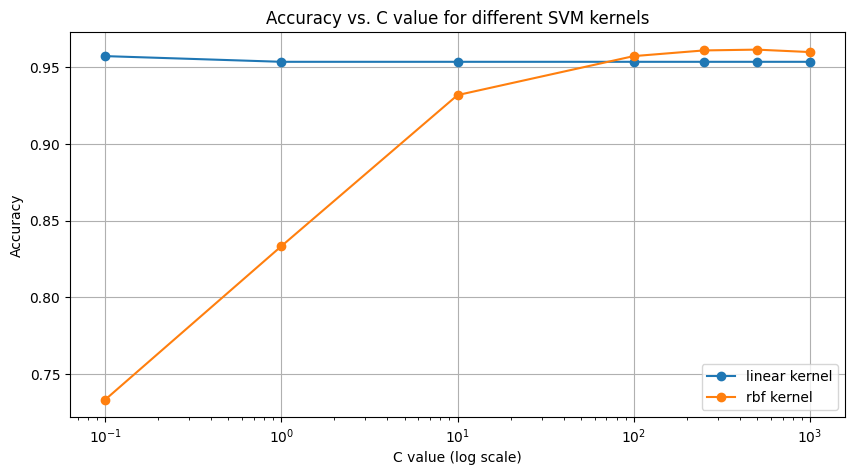

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Chuẩn bị dữ liệu đặc trưng và nhãn
X_tr_features = np.asarray(X_tr_features)
X_val_features = np.asarray(X_val_features)
X_test_features = np.asarray(X_test_features)

y_train = np.argmax(y_train, axis=1)  # Chuyển từ one-hot encoding sang nhãn số
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

# Huấn luyện mô hình SVM
C_values = [0.1, 1, 10, 100, 250,500,1000]
kernel_list = ['linear', 'rbf']
acc_list = []

max_acc = 0
best_C = None
best_kernel = None

for kernel in kernel_list:
    for C in C_values:
        svm_model = SVC(C=C, kernel=kernel)
        svm_model.fit(X_tr_features, y_train)
        y_val_pred = svm_model.predict(X_val_features)
        acc = accuracy_score(y_val, y_val_pred)
        acc_list.append((kernel, C, acc))
        
        if acc > max_acc:
            max_acc = acc
            best_C = C
            best_kernel = kernel

# Prepare data for plotting
linear_accuracies = [acc for kernel, C, acc in acc_list if kernel == 'linear']
rbf_accuracies = [acc for kernel, C, acc in acc_list if kernel == 'rbf']

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(C_values, linear_accuracies, label='linear kernel', marker='o')
plt.plot(C_values, rbf_accuracies, label='rbf kernel', marker='o')
plt.xscale('log')
plt.xlabel('C value (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. C value for different SVM kernels')
plt.legend()
plt.grid(True)
plt.show()

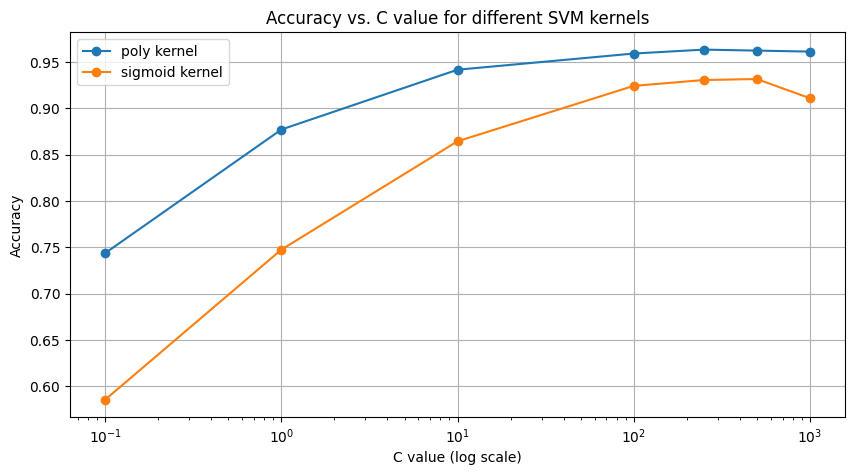

In [16]:
C_values = [0.1, 1, 10, 100, 250,500,1000]
kernel_list = ['poly', 'sigmoid']
acc_list = []

max_acc = 0
best_C = None
best_kernel = None

for kernel in kernel_list:
    for C in C_values:
        svm_model = SVC(C=C, kernel=kernel)
        svm_model.fit(X_tr_features, y_train)
        y_val_pred = svm_model.predict(X_val_features)
        acc = accuracy_score(y_val, y_val_pred)
        acc_list.append((kernel, C, acc))
        
        if acc > max_acc:
            max_acc = acc
            best_C = C
            best_kernel = kernel

# Prepare data for plotting
poly_accuracies = [acc for kernel, C, acc in acc_list if kernel == 'poly']
sigmoid_accuracies = [acc for kernel, C, acc in acc_list if kernel == 'sigmoid']

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(C_values, poly_accuracies, label='poly kernel', marker='o')
plt.plot(C_values, sigmoid_accuracies, label='sigmoid kernel', marker='o')
plt.xscale('log')
plt.xlabel('C value (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. C value for different SVM kernels')
plt.legend()
plt.grid(True)
plt.show()


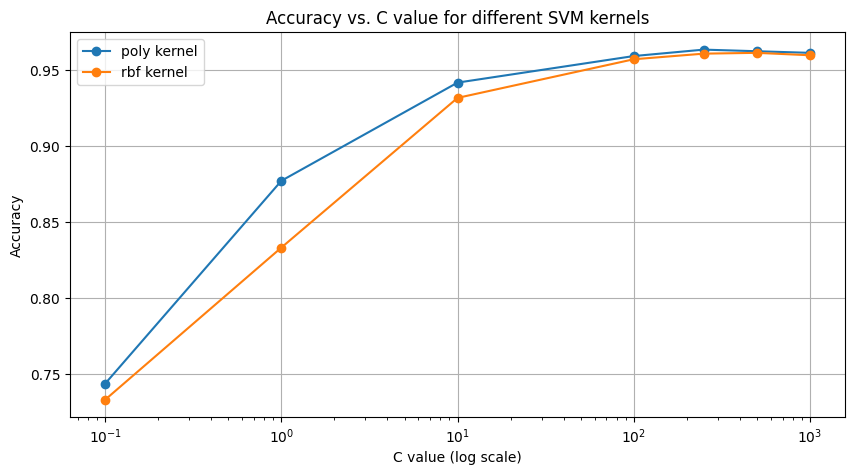

Best_C : 250
Best_kernel : poly


In [17]:

C_values = [0.1, 1, 10, 100, 250,500,1000]
kernel_list = ['poly', 'rbf']
acc_list = []

max_acc = 0
best_C = None
best_kernel = None

for kernel in kernel_list:
    for C in C_values:
        svm_model = SVC(C=C, kernel=kernel)
        svm_model.fit(X_tr_features, y_train)
        y_val_pred = svm_model.predict(X_val_features)
        acc = accuracy_score(y_val, y_val_pred)
        acc_list.append((kernel, C, acc))
        
        if acc > max_acc:
            max_acc = acc
            best_C = C
            best_kernel = kernel

# Prepare data for plotting
linear_accuracies = [acc for kernel, C, acc in acc_list if kernel == 'poly']
rbf_accuracies = [acc for kernel, C, acc in acc_list if kernel == 'rbf']

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(C_values, linear_accuracies, label='poly kernel', marker='o')
plt.plot(C_values, rbf_accuracies, label='rbf kernel', marker='o')
plt.xscale('log')
plt.xlabel('C value (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. C value for different SVM kernels')
plt.legend()
plt.grid(True)
plt.show()

print("Best_C :",best_C)
print("Best_kernel :",best_kernel)

In [18]:
svm_model = SVC(C = best_C, kernel= best_kernel)  # Hoặc có thể thử với các kernel khác như 'rbf'
svm_model.fit(X_tr_features, y_train)
y_test_pred = svm_model.predict(X_test_features)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.96%
Test Accuracy: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1081
           1       0.95      0.96      0.95       809

    accuracy                           0.96      1890
   macro avg       0.96      0.96      0.96      1890
weighted avg       0.96      0.96      0.96      1890

Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       557
           1       0.92      0.95      0.93       391

    accuracy                           0.94       948
   macro avg       0.94      0.94      0.94       948
weighted avg       0.94      0.94      0.94       948



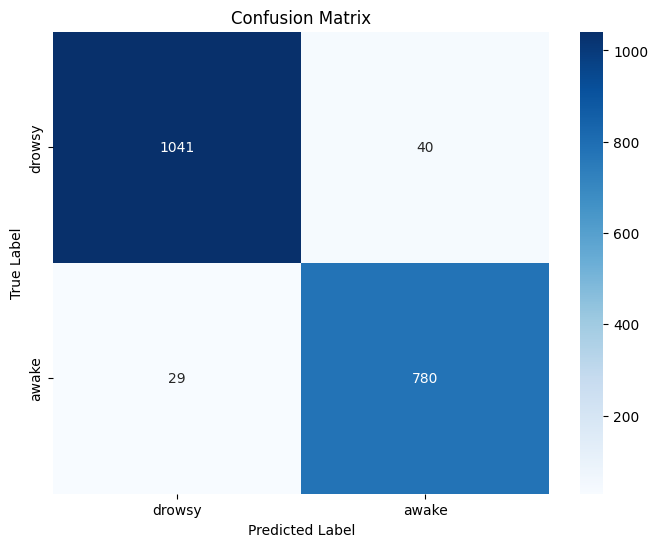

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_val_pred = svm_model.predict(X_val_features)
classes = ["drowsy", 'awake']
# Tính confusion matrix
conf_mat = confusion_matrix(y_val, y_val_pred)

# Vẽ confusion matrix bằng seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
Test Accuracy: 0.94%
Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       557
           1       0.92      0.95      0.93       391

    accuracy                           0.94       948
   macro avg       0.94      0.94      0.94       948
weighted avg       0.94      0.94      0.94       948

Demo classification report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55        11
           1       0.64      0.64      0.64        14

    accuracy                           0.60        25
   macro avg       0.59      0.59      0.59        25
weighted avg       0.60      0.60      0.60        25



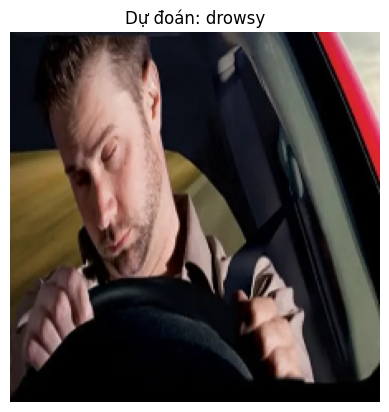

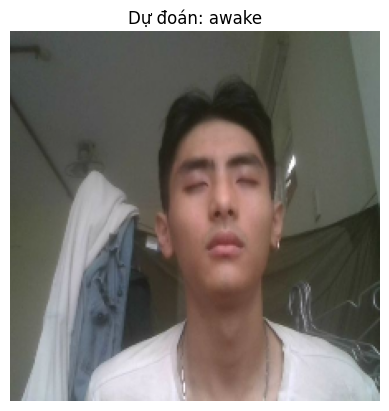

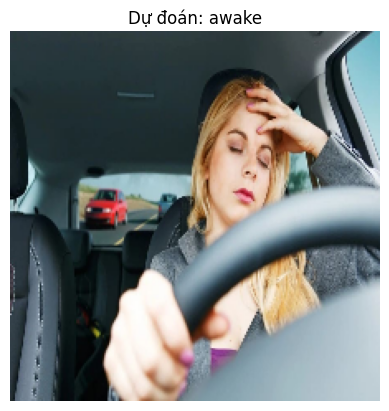

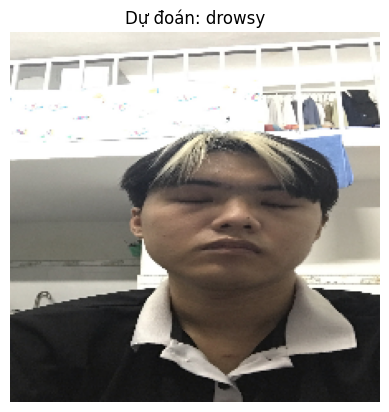

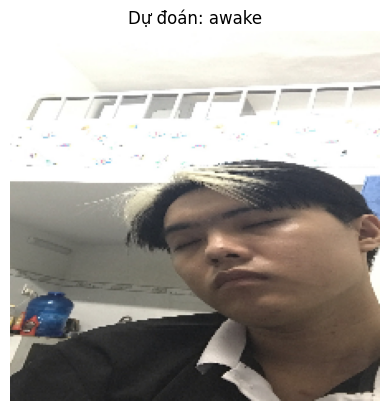

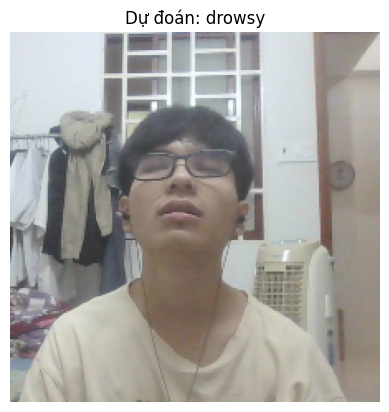

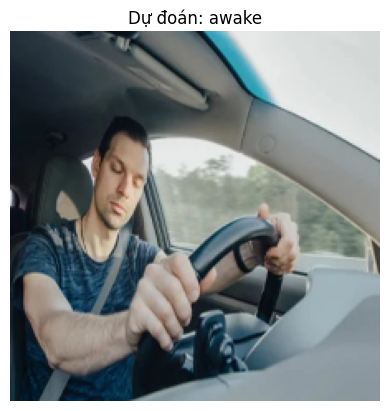

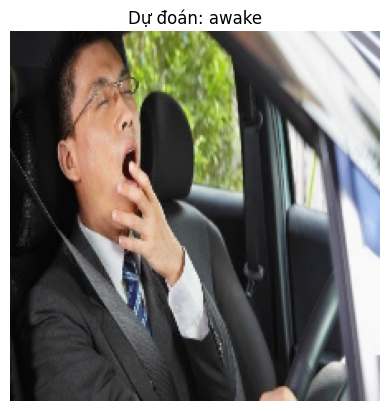

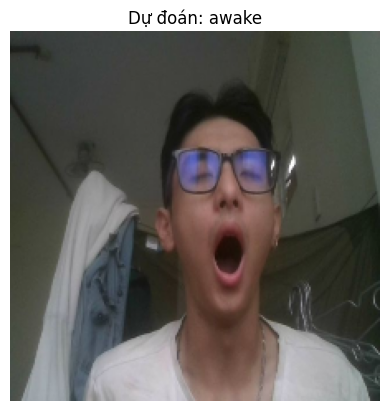

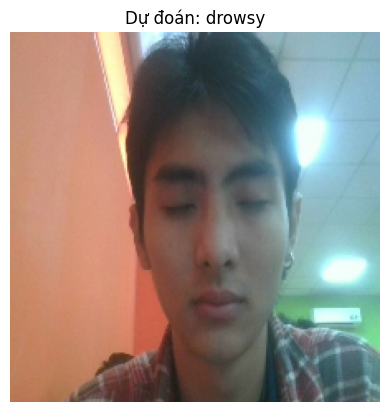

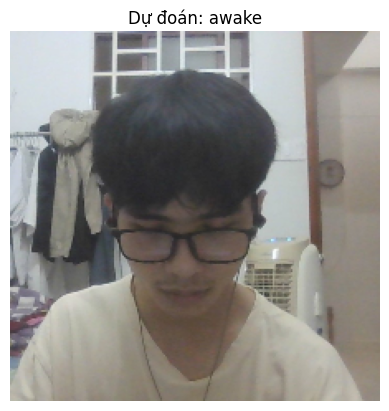

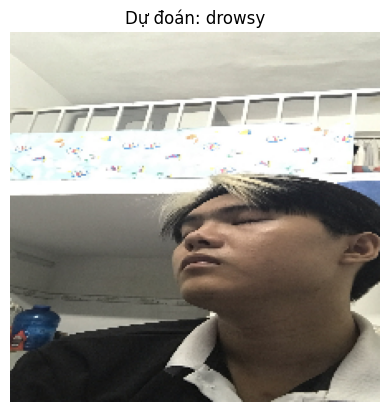

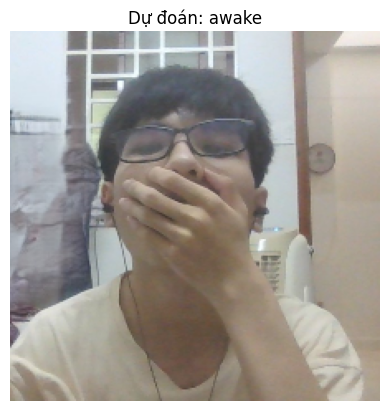

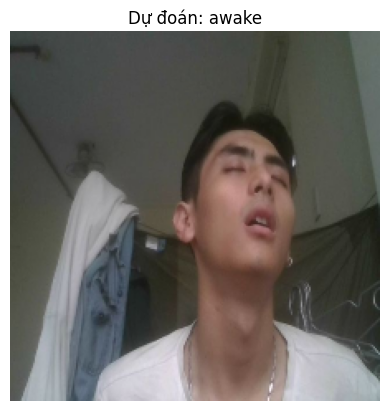

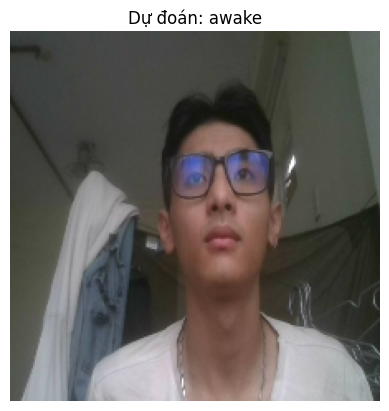

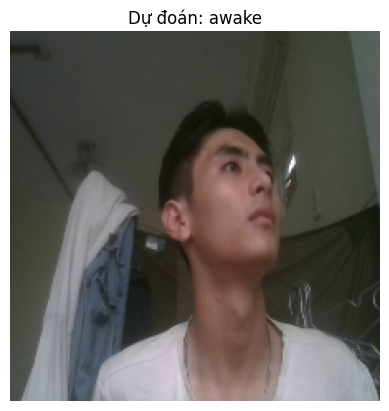

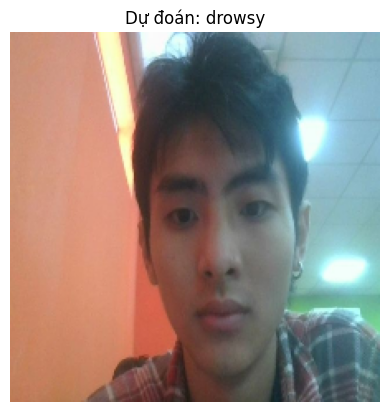

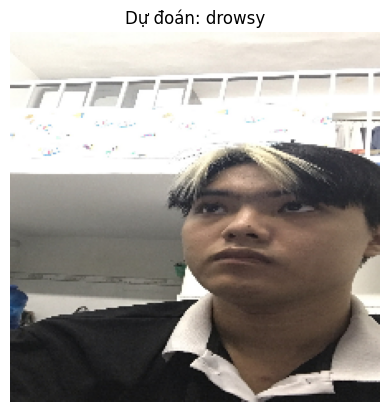

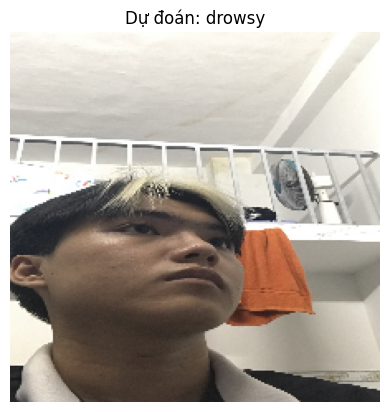

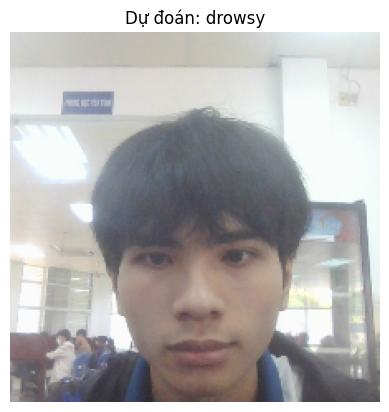

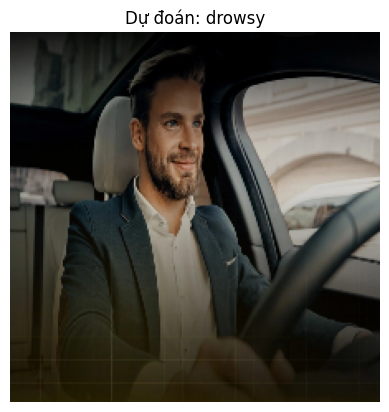

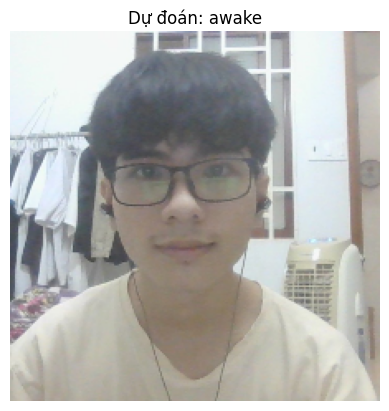

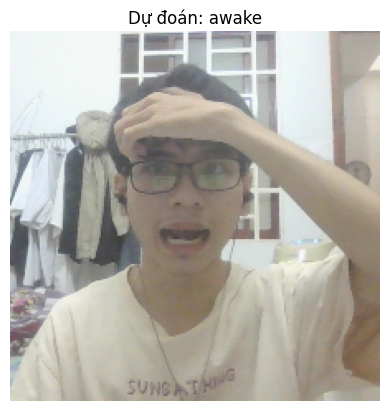

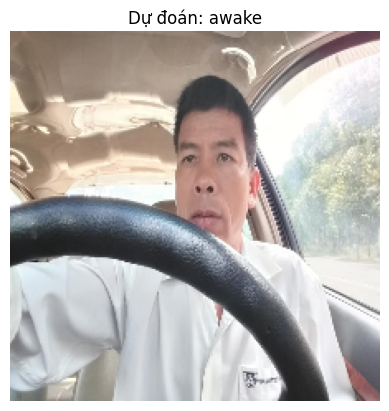

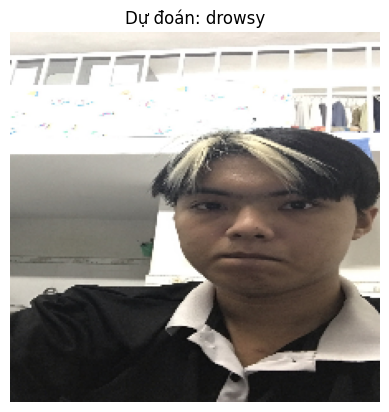

In [20]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

# Bước 1: Load ảnh từ đường dẫn
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize ảnh về kích thước 64x64
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển đổi ảnh về grayscale
            images.append(img)  # Chuyển đổi ảnh thành một vector 1 chiều
            labels.append(label)
    return images, labels

# Load ảnh drowsy
drowsy_folder = '/kaggle/input/demo-dataset/Demo_DDD/drowsy'
drowsy_images, drowsy_labels = load_images_from_folder(drowsy_folder, label=1)

# Bạn cần thêm thư mục cho ảnh awake và lặp lại các bước trên để load ảnh awake
awake_folder = '/kaggle/input/demo-dataset/Demo_DDD/awake'
awake_images, awake_labels = load_images_from_folder(awake_folder, label=0)

# Tổng hợp dữ liệu và nhãn
images = drowsy_images + awake_images
labels = drowsy_labels + awake_labels

# Chuyển đổi danh sách thành mảng numpy
X = np.array(images)
X = X/255
y = np.array(labels)
# Bước 3: Rút trích đặc trưng từ VGG19
# model_VGG19 = VGG19(include_top = False, input_shape = (img_size, img_size, no_channel), weights = 'imagenet')
# for layer in model_VGG19.layers:
#     layer.trainable = True

# inp = model_VGG19.input
# x = model_VGG19.output
# out = Flatten()(x)
# model = Model(inputs = inp, outputs = out)
X_feature = model.predict(X)
X_feature = np.asarray(X_feature)

# # Bước 4: Huấn luyện mô hình SVM
# svm_model = SVC(C = 250, kernel= 'poly')  # Hoặc có thể thử với các kernel khác như 'rbf'
# svm_model.fit(X_tr_features, y_train)
y_test_pred = svm_model.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}%')
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Bước 5: Dự đoán và đánh giá mô hình
y_pred = svm_model.predict(X_feature)
accuracy = accuracy_score(y, y_pred)
report = classification_report(y, y_pred)
print("Demo classification report:")
print(report)

# Hiển thị kết quả dự đoán
class_names = ['drowsy', 'awake']  # Thay đổi theo lớp thực tế của bạn
# print(f"Predicted class: {np.array(class_names)[y_pred]}")
    
for idx, image in enumerate(images):
    plt.imshow(image)
    plt.title(f"Dự đoán: {class_names[y_pred[idx]]}")
    plt.axis('off')
    plt.show()

In [21]:
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
